# Super Resolution

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
!pip install torchmetrics
!pip install diffusers[training]

In [3]:
!sudo pip uninstall -y transformer-engine

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import math
import copy
import cv2
import os
import json
import time

from PIL import Image
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from model import UNet
from dsr import DSRDataset
from pathlib import Path

from srd import SuperResolutionDataset

train_dataset = SuperResolutionDataset(data_path='flowers/train', resolution=128)
val_dataset = SuperResolutionDataset(data_path='flowers/valid', resolution=128)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=8,
    shuffle=True
)

In [19]:
root = Path('./dsr/')

with open(root / 'train_valid_test_split.json', 'r') as f:
    split = json.load(f)
    
train_dataset = DSRDataset(root, split['train'], resolution=128, real_lr=False)
val_dataset = DSRDataset(root, split['test'], resolution=128, real_lr=False)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=16,
    num_workers=1,
    shuffle=True,
    prefetch_factor=4
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=16,
    num_workers=1,
    shuffle=True,
    prefetch_factor=4
)

Loaded 5175 pairs for scenes ['0029', '0032', '0034', '0035', '0037', '0038', '0040', '0166', '0043', '0044', '0046', '0048', '0049', '0051', '0052', '0054', '0057', '0058', '0059', '0060', '0061', '0063', '0065', '0067', '0069', '0070', '0072', '0074', '0077', '0078', '0080', '0081', '0170', '0087', '0088', '0090', '0092', '0093', '0095', '0096', '0098', '0099', '0103', '0104', '0105', '0106', '0107', '0108', '0109', '0112', '0114', '0116', '0230', '0118', '0120', '0121', '0123', '0124', '0128', '0130', '0131', '0133', '0134', '0135', '0136', '0138', '0139', '0141', '0143', '0171', '0145', '0147', '0150', '0174', '0176', '0157', '0158', '0159', '0160', '0161', '0163', '0178', '0181', '0186', '0187', '0183', '0185', '0189', '0190', '0191', '0194', '0195', '0200', '0201', '0202', '0203', '0204', '0208', '0218', '0223'] and height None
Loaded 2532 pairs for scenes ['0175', '0169', '0154', '0030', '0180', '0228', '0214', '0229', '0151', '0055', '0071', '0225', '0153', '0102', '0156', '004

Time taken to get next batch of images: 2.038830280303955 seconds
(16, 3, 128, 128)
(16, 3, 128, 128)
mean: -0.024532944
variance: 0.15755132
min: -0.99264705
max: 1.0


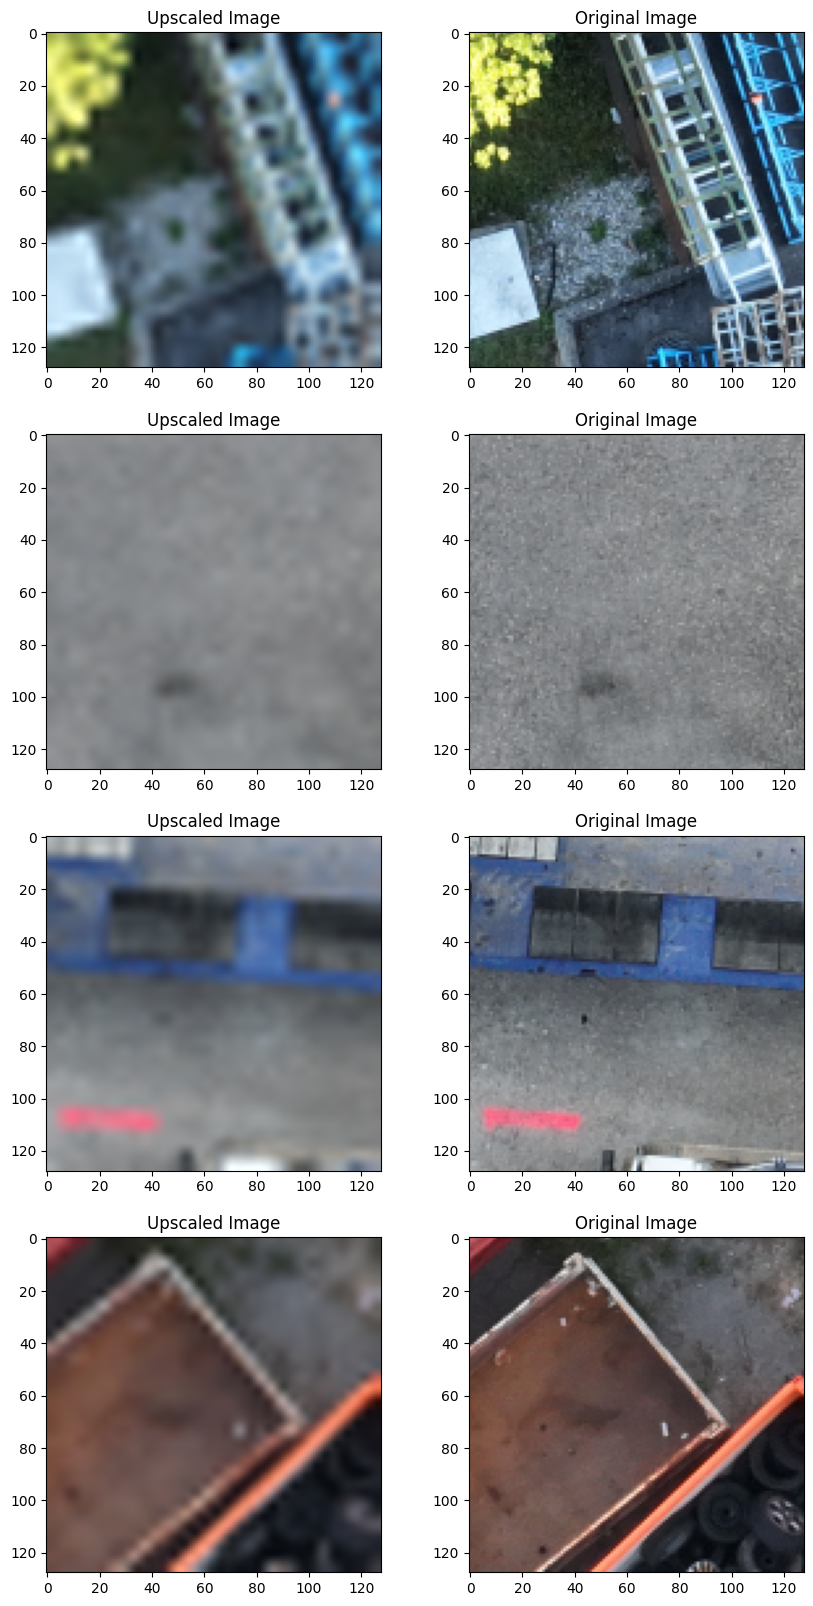

In [20]:
start_time = time.time()

images = next(iter(train_loader))
lowres_images = images[0].numpy()
highres_images = images[1].numpy()

elapsed_time = time.time() - start_time
print(f"Time taken to get next batch of images: {elapsed_time} seconds")

print(lowres_images.shape)
print(highres_images.shape)

print('mean:', highres_images.mean())
print('variance:', highres_images.var())
print('min:', highres_images.min())
print('max:', highres_images.max())

fig, axes = plt.subplots(figsize=(10, 20), nrows=4, ncols=2)
for i in range(4):
    ax = axes[i]

    lowres_image = (lowres_images[i] + 1) / 2
    highres_image = (highres_images[i] + 1) / 2

    ax[0].imshow(lowres_image.transpose(1, 2, 0))
    ax[0].set_title('Upscaled Image')

    ax[1].imshow(highres_image.transpose(1, 2, 0))
    ax[1].set_title('Original Image')

plt.show()

## U-Net

![Example Image](unet.png)

# Conditional generation

In [21]:
from diffusers import UNet2DModel, DDIMScheduler
from diffusers.optimization import get_cosine_schedule_with_warmup

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = UNet2DModel(
        sample_size=128,  # the target image resolution
        in_channels=6,  # the number of input channels, 3 for RGB images
        out_channels=3,  # the number of output channels
        layers_per_block=2,  # how many ResNet layers to use per UNet block
        block_out_channels=(64, 128, 256),  # the number of output channels for each UNet block
        norm_num_groups=1,
        down_block_types=(
            "DownBlock2D",  # a regular ResNet downsampling block
            "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
            "DownBlock2D",
        ),
        up_block_types=(
            "UpBlock2D",  # a regular ResNet upsampling block
            "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
            "UpBlock2D",
        ),
    ).to(device)

criterion = nn.MSELoss()
epochs = 2
T = 2000
diffusion_scheduler = DDIMScheduler(num_train_timesteps=T, beta_schedule='squaredcos_cap_v2')
tensorboard_path="./runs/diffusion-525M-dsr-256R-cosine-1e-4"

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=(len(train_loader) * epochs),
)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters:", num_params, device)

Number of parameters: 14739779 cuda


In [ ]:
from train import train

train(model, diffusion_scheduler, train_loader, val_loader, epochs, device, optimizer, lr_scheduler, criterion, tensorboard_path, num_accumulation_steps=4)

In [ ]:
torch.save(model.state_dict(), 'models/dsr_sr.pth')

# Inference

In [22]:
model.load_state_dict(torch.load('models/dsr_sr.pth'))

<All keys matched successfully>

  0%|          | 0/100 [00:00<?, ?it/s]

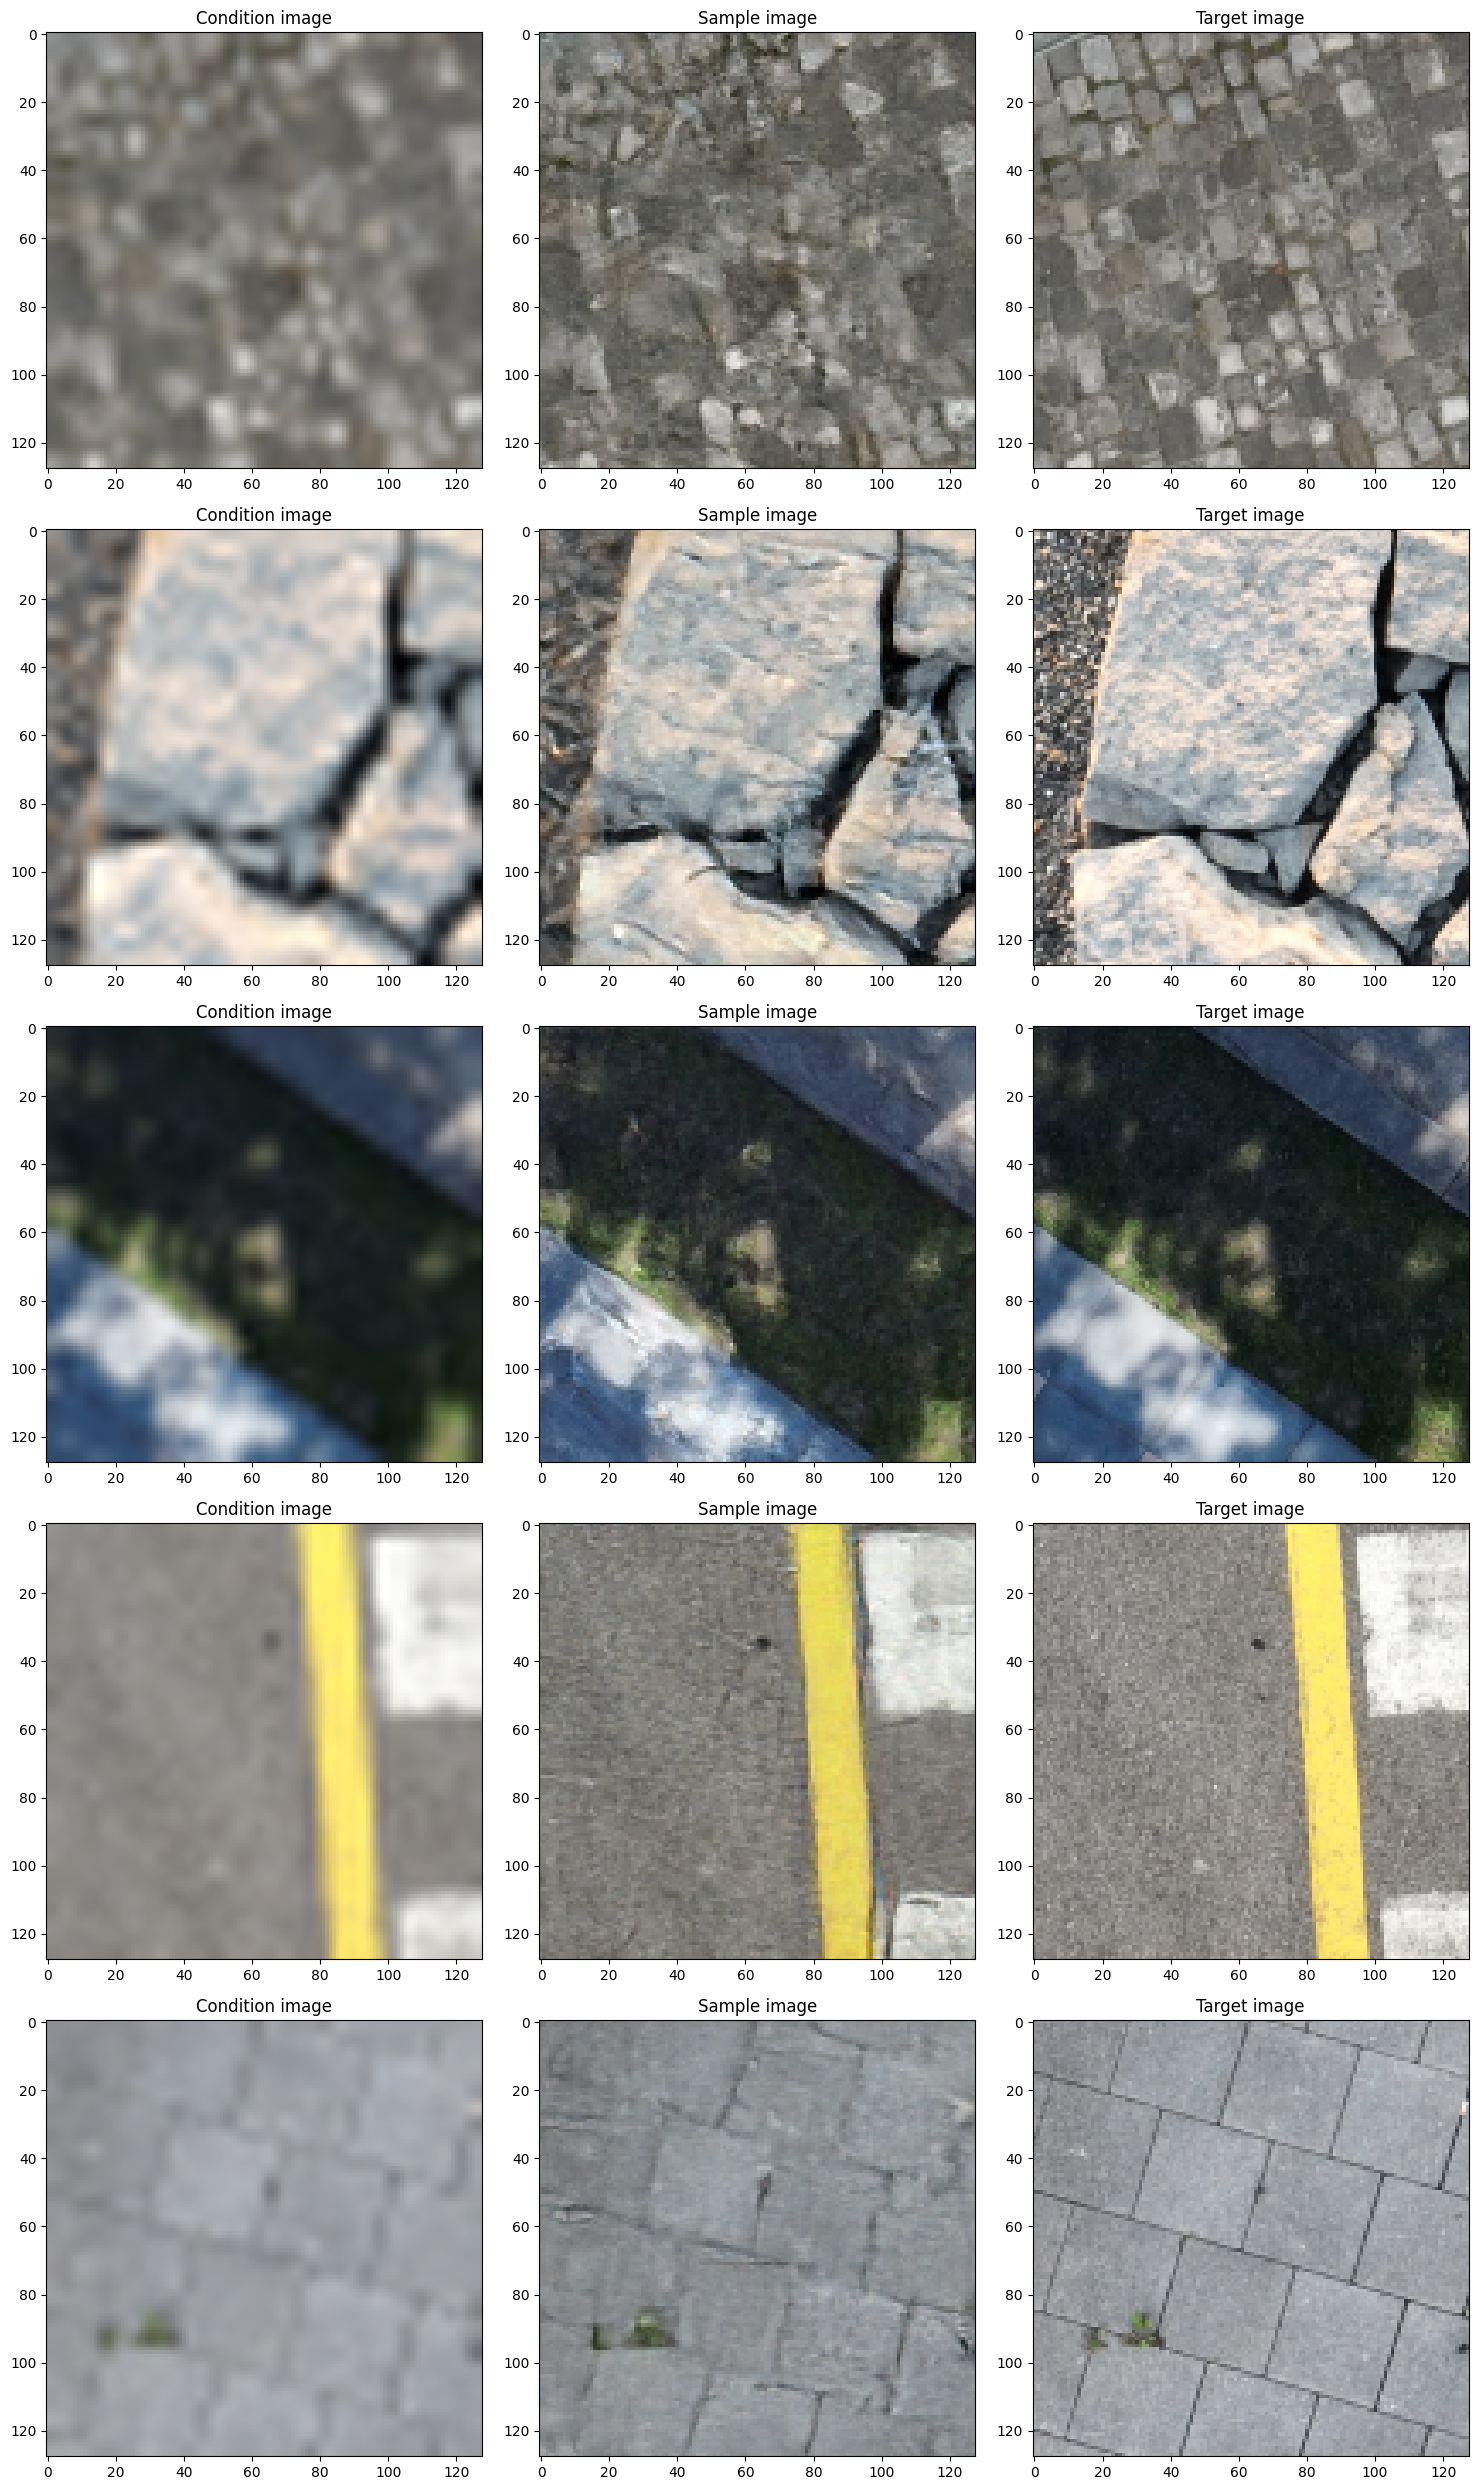

In [23]:
from samplers import DDIMPipeline 

X, y = next(iter(val_loader))

X = X.to(device)
y = y.to(device)

pipeline = DDIMPipeline(unet=model, scheduler=diffusion_scheduler)
            
generated_images = pipeline(
    X,
    batch_size=X.shape[0],
    num_inference_steps=100
)

X = (X + 1) / 2
y = (y + 1) / 2

num_samples = 5
fig, ax = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))

for i in range(num_samples):
    ax[i, 0].imshow(X[i].permute(1, 2, 0).cpu().numpy())
    ax[i, 0].set_title("Condition image")

    ax[i, 1].imshow(generated_images[i].permute(1, 2, 0).cpu().numpy())
    ax[i, 1].set_title("Sample image")

    ax[i, 2].imshow(y[i].permute(1, 2, 0).cpu().numpy())
    ax[i, 2].set_title("Target image")

plt.tight_layout()
plt.show()